In [52]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b
from statistics import variance
import math

In [53]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,1,1)

In [54]:
market = Market()
speculation_db = ADatabase("short_included")

In [55]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [56]:
speculation_db.connect()
t = speculation_db.retrieve("trades")
speculation_db.disconnect()

In [57]:
t

,year,week,ticker,delta,returns,floored_returns,position,actual_returns,value,classification,ceiling,floor,hedge,signal,req,training_years
0,2020.0,2.0,NVR,0.121995,1.006518,1.006518,0,1.006518,True,False,True,True,False,0.05,0.05,4
1,2020.0,3.0,MNST,0.968542,1.026380,1.026380,0,1.026380,True,False,True,True,False,0.05,0.05,4
2,2020.0,5.0,FCX,0.202091,0.982301,0.982301,0,0.982301,True,False,True,True,False,0.05,0.05,4
3,2020.0,6.0,PARA,0.148838,1.033959,1.033959,0,1.033959,True,False,True,True,False,0.05,0.05,4
4,2020.0,7.0,F,0.164855,1.000000,1.000000,0,1.000000,True,False,True,True,False,0.05,0.05,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,2022.0,47.0,CHTR,0.061156,0.997199,0.997199,9,0.997199,True,False,False,False,False,0.05,0.05,4
5516,2022.0,48.0,DLTR,0.055956,1.032082,1.032082,9,1.032082,True,False,False,False,False,0.05,0.05,4
5517,2022.0,49.0,EOG,0.063774,0.952109,0.952109,9,0.952109,True,False,False,False,False,0.05,0.05,4
5518,2022.0,50.0,BKNG,0.088822,1.053364,1.053364,9,1.053364,True,False,False,False,False,0.05,0.05,4


In [58]:
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
bench["day"] = [x.weekday() for x in bench["date"]]
bench_returns = bench[bench["day"]==0]
bench_returns[f"bench_return"] = (bench_returns["adjclose"].shift(-4) - bench_returns["adjclose"].shift(-1)) / bench_returns["adjclose"].shift(-1)
bench_returns["variance"] = bench_returns["bench_return"].rolling(window=100).var()
bench_returns

,date,open,high,low,close,adjclose,volume,year,quarter,week,day,bench_return,variance
4,2018-05-07,266.890015,268.019989,266.109985,266.920013,245.114182,55304900,2018,2,19,0,0.020441,NaN
9,2018-05-14,273.339996,274.079987,272.359985,272.980011,250.679092,54790600,2018,2,20,0,0.016212,NaN
14,2018-05-21,273.010010,273.980011,272.570007,273.369995,251.037216,58025900,2018,2,21,0,-0.009760,NaN
23,2018-06-04,274.529999,275.190002,274.260010,274.899994,252.442200,45385200,2018,2,23,0,-0.019670,NaN
28,2018-06-11,278.440002,279.369995,278.309998,278.559998,255.803162,58892500,2018,2,24,0,0.004845,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,2023-03-27,398.119995,398.920013,395.559998,396.489990,396.489990,74010400,2023,1,13,0,0.004088,0.001874
1239,2023-04-03,408.850006,411.369995,408.440002,410.950012,410.950012,67391100,2023,2,14,0,NaN,NaN
1243,2023-04-10,406.609985,409.690002,405.970001,409.609985,409.609985,63681000,2023,2,15,0,NaN,NaN
1248,2023-04-17,412.369995,413.959991,411.089996,413.940002,413.940002,66436400,2023,2,16,0,NaN,NaN


In [59]:
tyields = pd.read_csv("./csv_files/FED/DGS1.csv")
tyields = p.column_date_processing(tyields)
tyields["dgs1"] = tyields["dgs1"].replace(".",0)
tyields["dgs1"] = tyields["dgs1"].astype("float")
tyields["yield"] = [1+(x/100) for x in tyields["dgs1"]]
tyields["weekly_yield"] = [math.exp(math.log(x)/52) for x in tyields["yield"]]
tyields = tyields[(tyields["year"]>=2020) & (tyields["year"]<2023)].groupby("year").mean().cumprod()
tyields

,dgs1,quarter,week,yield,weekly_yield
year,,,,,
2020,0.354580,2.507634,27.099237,1.003546,1.000068
2021,0.035458,6.302711,720.881226,1.004549,1.000087
2022,0.094963,15.805260,19103.35249,1.031453,1.000594


In [60]:
reqs = [0.05]
signals = [0.05]
values = [True]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [False]
parameters = []
positions = 10
training_year = 4
for value in values:
    for classification in classifications:
        for ceiling in ceilings:
            for floor in floors:
                for hedge in hedges:
                    for signal in signals:
                        for req in reqs:
                            parameter = {"value":value
                                         ,"classification":classification
                                         ,"ceiling":ceiling
                                         ,"floor":floor
                                         ,"hedge":hedge
                                         ,"signal":signal
                                         ,"req":req
                                         ,"training_years":training_year}
                            parameters.append(parameter)

In [61]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        if ledger.index.size > 0:
            portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
            counted_columns = [x for x in range(positions)]
            cumulative = portfolio[[i for i in counted_columns]].cumprod()
            cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
            cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
            cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
            cumulative = cumulative.merge(bench_returns[["date","adjclose","bench_return","variance"]],on="date",how="left")
            cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
            cumulative["return"] = cumulative["pv"].pct_change().fillna(1)
            cumulative["beta"] = cumulative[["return","bench_return"]].cov().iloc[0][1]/cumulative["variance"].iloc[-1]
            cumulative["rrr"] = tyields["yield"].iloc[-1] + cumulative["beta"].iloc[-1]*(cumulative["bench"].iloc[-1]-tyields["yield"].iloc[-1])
            cumulative["sharpe"] = (cumulative["pv"] - tyields["yield"].iloc[-1]) / cumulative["beta"].iloc[-1]
            for index_stuff in indexer:
                cumulative[index_stuff] = parameter[index_stuff]
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [62]:
a

,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
137,True,False,True,True,False,0.05,0.05,4,1.373741,0.057402,1.042950,5.963029
137,True,False,True,False,False,0.05,0.05,4,0.766123,-0.002027,1.031047,130.870174
137,True,False,False,True,False,0.05,0.05,4,1.364641,0.053182,1.042105,6.265040
137,True,False,False,False,False,0.05,0.05,4,0.722609,-0.014685,1.028512,21.031059


In [63]:
a.sort_values("pv",ascending=False)

,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
137,True,False,True,True,False,0.05,0.05,4,1.373741,0.057402,1.042950,5.963029
137,True,False,False,True,False,0.05,0.05,4,1.364641,0.053182,1.042105,6.265040
137,True,False,True,False,False,0.05,0.05,4,0.766123,-0.002027,1.031047,130.870174
137,True,False,False,False,False,0.05,0.05,4,0.722609,-0.014685,1.028512,21.031059


In [64]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")

In [65]:
ledger.sort_values(["year","week","delta"]).head(30)

,year,week,ticker,delta,actual_returns,position,GICS Sector
1242,2020.0,2.0,KEY,0.061511,0.999486,9,Financials
1104,2020.0,2.0,LKQ,0.064037,0.983271,8,Consumer Discretionary
966,2020.0,2.0,PKG,0.066062,1.007916,7,Materials
828,2020.0,2.0,FITB,0.066689,0.996985,6,Financials
690,2020.0,2.0,F,0.069026,1.000000,5,Consumer Discretionary
552,2020.0,2.0,DOW,0.069369,0.986779,4,Materials
414,2020.0,2.0,HBAN,0.069666,0.997918,3,Financials
276,2020.0,2.0,AZO,0.081196,1.011490,2,Consumer Discretionary
138,2020.0,2.0,INCY,0.101115,0.991314,1,Health Care
0,2020.0,2.0,NVR,0.121995,1.006518,0,Consumer Discretionary


In [66]:
ledger

,year,week,ticker,delta,actual_returns,position,GICS Sector
0,2020.0,2.0,NVR,0.121995,1.006518,0,Consumer Discretionary
1,2020.0,3.0,MNST,0.968542,1.026380,0,Consumer Staples
2,2020.0,5.0,FCX,0.202091,0.982301,0,Materials
3,2020.0,6.0,PARA,0.148838,1.033959,0,Communication Services
4,2020.0,7.0,F,0.164855,1.000000,0,Consumer Discretionary
...,...,...,...,...,...,...,...
1375,2022.0,47.0,CHTR,0.061156,0.997199,9,Communication Services
1376,2022.0,48.0,DLTR,0.055956,1.032082,9,Consumer Discretionary
1377,2022.0,49.0,EOG,0.063774,0.952109,9,Energy
1378,2022.0,50.0,MRNA,0.078046,0.978485,9,Health Care


In [67]:
metric = "position"

In [68]:
portfolio = ledger.pivot_table(index=["year","week"],columns=metric,values="actual_returns").fillna(1).reset_index()

In [69]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,1.006518,0.991314,1.011490,0.997918,0.986779,1.000000,0.996985,1.007916,0.983271,0.999486,2020-W2,2020-01-06,0.998168,307.349365,1.000000
1,1.033070,0.972010,1.026095,0.991441,0.937440,0.996155,1.004496,0.991972,1.017123,0.984001,2020-W3,2020-01-13,0.995380,311.442413,1.013317
2,1.014786,1.023392,1.024731,0.983617,0.904831,0.968445,0.981280,1.017091,1.012126,0.981831,2020-W5,2020-01-27,0.991213,307.216431,0.999567
3,1.049247,1.033539,1.076764,0.997319,0.870000,0.983903,0.947673,1.041683,0.980526,0.999648,2020-W6,2020-02-03,0.998030,307.805176,1.001483
4,1.049247,1.030484,1.022926,1.006548,0.882927,1.057135,0.979824,0.989598,0.972536,1.000532,2020-W7,2020-02-10,0.999176,317.833649,1.034112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2.704897,1.177623,0.903295,2.225062,1.197957,0.616010,1.716879,1.551582,0.747945,1.283470,2022-W47,2022-11-21,1.412472,391.292938,1.273121
134,2.820097,1.186234,0.895416,2.238589,1.247140,0.624388,1.773280,1.568899,0.735663,1.324646,2022-W48,2022-11-28,1.441435,392.601929,1.277380
135,2.781176,1.206005,0.894712,2.255393,1.184783,0.595272,1.781561,1.572701,0.721786,1.261208,2022-W49,2022-12-05,1.425460,396.251160,1.289253
136,2.648972,1.145705,0.849977,2.142624,1.163267,0.565509,1.771877,1.522278,0.760303,1.234073,2022-W50,2022-12-12,1.380458,395.616516,1.287188


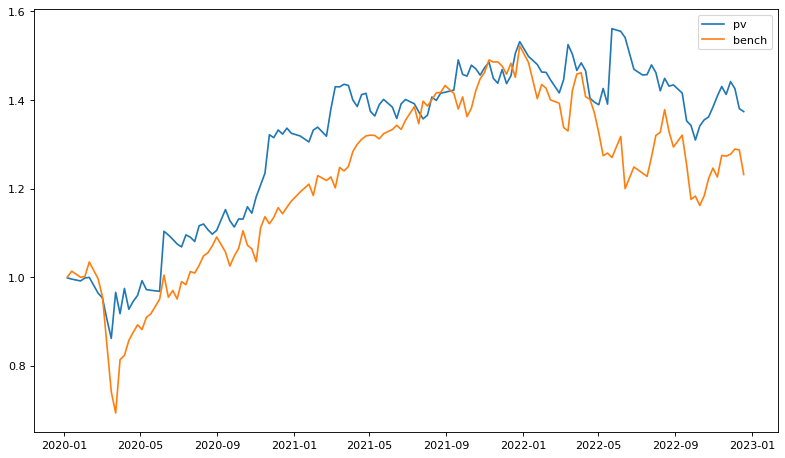

In [70]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

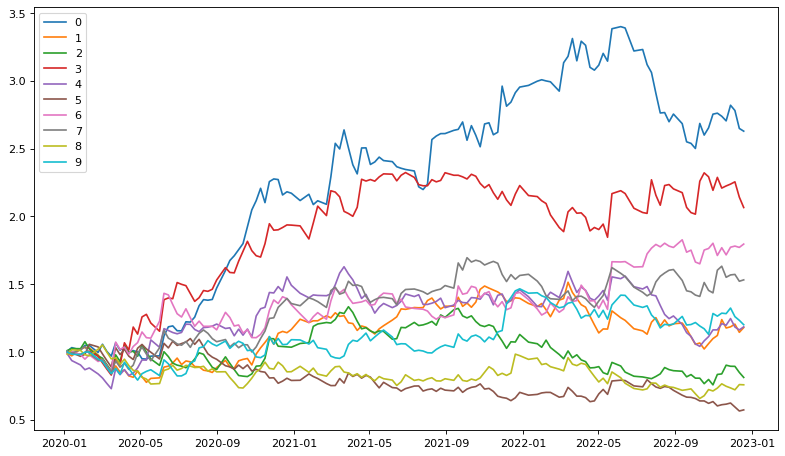

In [71]:
plt.figure(figsize=(12, 7), dpi=80)
for i in counted_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
    plt.legend(counted_columns)
plt.show()


In [72]:
ledger.groupby(["GICS Sector"]).mean().sort_values("delta",ascending=False)

,year,week,delta,actual_returns,position
GICS Sector,,,,,
Consumer Staples,2021.231707,25.841463,0.539895,0.997925,2.817073
Industrials,2020.913978,25.591398,0.166533,1.006286,4.935484
Financials,2020.863636,23.204545,0.157344,1.004926,5.806818
Consumer Discretionary,2020.895000,27.655000,0.147907,1.004414,3.840000
Communication Services,2021.155556,27.400000,0.124700,0.999483,4.377778
Real Estate,2020.985507,29.797101,0.123314,1.002898,5.565217
Utilities,2021.166667,30.444444,0.116244,0.983801,4.777778
Energy,2020.740331,31.878453,0.113248,1.001464,4.618785
Information Technology,2021.163934,26.688525,0.108016,1.011880,5.229508


In [73]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2.020000e+03,2.000000e+00,1.000000,1.000320,1.000000,1.000000,0.998130,0.991314,1.000000,1.000000,0.997348,1.000000,1.000000
1,4.080400e+06,6.000000e+00,0.984507,1.001737,1.011268,1.000000,1.005650,0.941749,1.000000,1.000000,0.997348,1.000000,1.000000
2,8.242408e+09,3.000000e+01,0.950261,1.007464,1.011268,1.000000,1.002818,0.941749,1.000000,1.000000,0.992198,1.000000,1.000000
3,1.664966e+13,1.800000e+02,0.982531,0.993598,1.011268,1.011706,1.002818,0.941749,1.000000,1.000000,0.992198,1.000000,1.000000
4,3.363232e+16,1.260000e+03,0.991623,0.991059,1.011268,1.031386,1.002818,0.925202,1.000000,1.000000,0.992198,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,inf,5.941791e+179,0.821485,1.407874,0.844687,0.773243,1.282421,0.841246,1.301074,1.744434,0.874340,1.197661,0.841332
134,inf,2.852060e+181,0.827492,1.434738,0.880662,0.769639,1.324550,0.875784,1.301074,1.744434,0.874340,1.213950,0.841332
135,inf,1.397509e+183,0.841284,1.439559,0.868508,0.732563,1.324550,0.877907,1.301074,1.752580,0.857847,1.213950,0.841332
136,inf,6.987546e+184,0.801293,1.432278,0.868508,0.732563,1.270203,0.846515,1.301074,1.752580,0.857847,1.213950,0.799265
